In [1]:
import tensorflow as tf
import tensorflow_hub as hub 
import cv2
from matplotlib import pyplot as plt
import numpy as np
import time 
import os
import json

In [2]:
# For better visualization of decimals numbers:
np.set_printoptions(precision=10, suppress=True)

In [3]:
model = tf.saved_model.load("models/saved_model")
movenent = model.signatures['serving_default']

In [4]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 6, (0,255,0), -1)

In [5]:
# Define connections between our point 
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [6]:
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 4)

In [7]:
# loop through each person detected and render 
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold):
    for person in keypoints_with_scores:
        draw_connections(frame, person, edges, confidence_threshold)
        draw_keypoints(frame, person, confidence_threshold)

In [8]:
cap = cv2.VideoCapture(0) 
while cap.isOpened(): 
    ret, frame = cap.read()
    
    start_time = time.time()
    
    
    
    
    # Resize image
    img = frame.copy()
    img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 128,256)
    input_img = tf.cast(img,dtype=tf.int32)
    
    # Detection section
    results = movenent(input_img)
    keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))
    
    # Render keypoints
    loop_through_people(frame, keypoints_with_scores, EDGES, 0.3)
    
    processing_time = time.time() - start_time
    time_remaining = max(int((1.0/20 - processing_time) * 1000), 1)
    
    # print("---------Frame Data---------")
    # print(keypoints_with_scores)
    
    cv2.imshow('Movenet Multipose', frame)
    
    if cv2.waitKey(time_remaining) & 0xFF == ord('q'):
        break
        
cap.release() 
cv2.destroyAllWindows()

In [9]:
frame.shape
#(Hauteur , largeur , RGB )

(480, 640, 3)

In [10]:
352 / 32

11.0

In [17]:

import string


def video_to_image(video_path, start_second, end_second, num_images, keypoints_file):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Erreur : Impossible d'ouvrir la vidéo.")
        return

    fps = cap.get(cv2.CAP_PROP_FPS)
    start_frame = int(start_second * fps)
    end_frame = int(end_second * fps)
    total_frames = end_frame - start_frame
    frame_interval = max(total_frames // num_images, 1)
    confidence_threshold = 0.3

    image_folder = "video_frames"
    if not os.path.exists(image_folder):
        os.makedirs(image_folder)

    all_frames = []
    print("all_frames", all_frames)
    frame_count = 0
    saved_frame_count = 0
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    while frame_count < total_frames and saved_frame_count < num_images:
        frame_persons_keypoints = []
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_interval == 0:
            img = tf.image.resize_with_pad(tf.expand_dims(frame, axis=0), 128, 256)
            input_img = tf.cast(img, dtype=tf.int32)

            results = movenent(input_img)
            keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))
            for person in keypoints_with_scores: 
                i = 0
                for keypoint in person:
                    if keypoint[2] > confidence_threshold:
                        i += 1
                if i >= 5:
                    frame_persons_keypoints.append(person.tolist())  # Convertit en liste pour JSON
            all_frames.append(frame_persons_keypoints)
            image_path = os.path.join(image_folder, f"frame_{saved_frame_count}.jpg")
            cv2.imwrite(image_path, frame)
            print(f"Frame sauvegardée : {image_path}")

            saved_frame_count += 1

        frame_count += 1
    for i,frame in enumerate(all_frames[12:]):
        print(i,frame)
    # Conversion de la liste de tous les keypoints en chaîne JSON et écriture dans le fichier
    enregistrer_tableau(all_frames,keypoints_file)

    cap.release()
    cv2.destroyAllWindows()
    print(f"Terminé. {saved_frame_count} frames ont été sauvegardées et les keypoints enregistrés dans {keypoints_file}.")



    


#video_path = "How To Make Fresh Orange Juice (Nigerian Food!).mp4"
#num_images = 20  # Sauvegarde une frame toutes les 60 frames
#start_second = 200  
#end_second = 220    
#video_to_image(video_path, start_second, end_second , num_images, "keypoints.txt")
# keypoints = results["output_0"].numpy()[:,:,:51]
# print(keypoints.shape)
# keypoints.reshape((6,17,3))
def enregistrer_tableau(tableau, fichier):
    with open(fichier, 'w', encoding='utf-8') as f:
        json.dump(tableau, f, indent=2)

video_to_image("./data/input/IMG_1077.MOV", 0, 8, 25, "./data/output/IMG_1077.txt")


all_frames []
Frame sauvegardée : video_frames\frame_0.jpg
Frame sauvegardée : video_frames\frame_1.jpg
Frame sauvegardée : video_frames\frame_2.jpg
Frame sauvegardée : video_frames\frame_3.jpg
Frame sauvegardée : video_frames\frame_4.jpg
Frame sauvegardée : video_frames\frame_5.jpg
Frame sauvegardée : video_frames\frame_6.jpg
Frame sauvegardée : video_frames\frame_7.jpg
Frame sauvegardée : video_frames\frame_8.jpg
Frame sauvegardée : video_frames\frame_9.jpg
Frame sauvegardée : video_frames\frame_10.jpg
Frame sauvegardée : video_frames\frame_11.jpg
Frame sauvegardée : video_frames\frame_12.jpg
Frame sauvegardée : video_frames\frame_13.jpg
Frame sauvegardée : video_frames\frame_14.jpg
0 [[[0.6388494968414307, 0.3552979826927185, 0.3382503390312195], [0.5762262344360352, 0.34920695424079895, 0.3175552487373352], [0.6002212762832642, 0.36030086874961853, 0.3418818712234497], [0.5686668157577515, 0.2843901813030243, 0.16881678998470306], [0.6067457795143127, 0.3482508659362793, 0.49024286

In [21]:
for filename in os.listdir('data/input/Utiliser_un_ordinateur'):
    video_path = os.path.join('data/input/Utiliser_un_ordinateur/',filename)
    print(video_path)
    video_to_image(video_path, 0, 8, 25, os.path.join('data/output/Utiliser_un_ordinateur',filename))

data/input/Utiliser_un_ordinateur/IMG_1078.MOV
all_frames []
Frame sauvegardée : video_frames\frame_0.jpg
Frame sauvegardée : video_frames\frame_1.jpg
Frame sauvegardée : video_frames\frame_2.jpg
Frame sauvegardée : video_frames\frame_3.jpg
Frame sauvegardée : video_frames\frame_4.jpg
Frame sauvegardée : video_frames\frame_5.jpg
Frame sauvegardée : video_frames\frame_6.jpg
Frame sauvegardée : video_frames\frame_7.jpg
Frame sauvegardée : video_frames\frame_8.jpg
Frame sauvegardée : video_frames\frame_9.jpg
Frame sauvegardée : video_frames\frame_10.jpg
Frame sauvegardée : video_frames\frame_11.jpg
Frame sauvegardée : video_frames\frame_12.jpg
Frame sauvegardée : video_frames\frame_13.jpg
Frame sauvegardée : video_frames\frame_14.jpg
Frame sauvegardée : video_frames\frame_15.jpg
Frame sauvegardée : video_frames\frame_16.jpg
Frame sauvegardée : video_frames\frame_17.jpg
Frame sauvegardée : video_frames\frame_18.jpg
Frame sauvegardée : video_frames\frame_19.jpg
Frame sauvegardée : video_fra

In [8]:
video_to_image("./data/input/IMG_1077.MOV", 0, 8, 25, "./data/output/IMG_1077.txt")

[]
all_frames []
Frame sauvegardée : video_frames\frame_0.jpg
Frame sauvegardée : video_frames\frame_1.jpg
Frame sauvegardée : video_frames\frame_2.jpg
Frame sauvegardée : video_frames\frame_3.jpg
Frame sauvegardée : video_frames\frame_4.jpg
Frame sauvegardée : video_frames\frame_5.jpg
Frame sauvegardée : video_frames\frame_6.jpg
Frame sauvegardée : video_frames\frame_7.jpg
Frame sauvegardée : video_frames\frame_8.jpg
Frame sauvegardée : video_frames\frame_9.jpg
Frame sauvegardée : video_frames\frame_10.jpg
Frame sauvegardée : video_frames\frame_11.jpg
Frame sauvegardée : video_frames\frame_12.jpg
Frame sauvegardée : video_frames\frame_13.jpg
Frame sauvegardée : video_frames\frame_14.jpg
[[array([[0.62725204, 0.56460387, 0.5317093 ],
       [0.60692513, 0.5738824 , 0.4207388 ],
       [0.5979467 , 0.5557116 , 0.45183578],
       [0.6028097 , 0.5798949 , 0.44721454],
       [0.5823923 , 0.53152007, 0.4043522 ],
       [0.6736973 , 0.58367026, 0.73343664],
       [0.6889228 , 0.49703306,

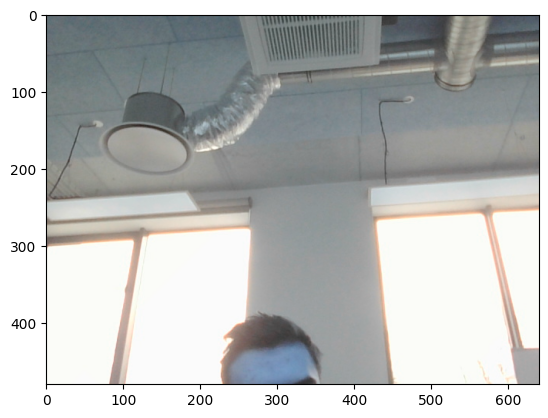

In [13]:
plt.imshow(frame)

In [14]:
frame.shape

(480, 640, 3)

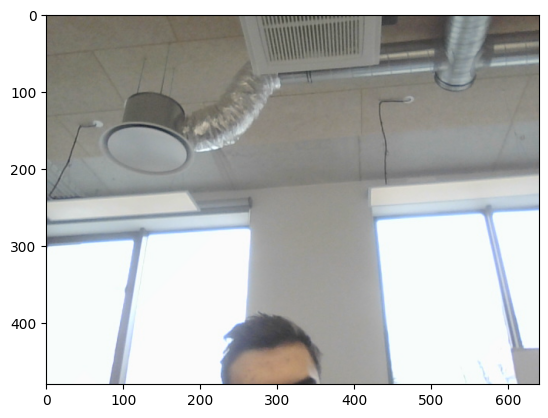

In [15]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

### Résultats du premier modèle stockés dans la varaiable "results" 
### On a 17 points soit 51 coordonnées représentant nos keypoints (y, x et le score de prédiction), les 5 dernieres valeurs présentes dans la variable "results" représentent les "bounding box coordinates" -> #TODO : voir cque sont ces 5 points j'ai pas trop compris pour l'instant

In [16]:
# on récupere juste les 51 premières
keypoints = results["output_0"].numpy()[:,:,:51]
print(keypoints.shape)
keypoints.reshape((6,17,3))

(1, 6, 51)


array([[[0.91912884  , 0.4268139   , 0.29901746  ],
        [0.9099888   , 0.42986512  , 0.287512    ],
        [0.89673424  , 0.4250143   , 0.25882533  ],
        [0.9174501   , 0.4473826   , 0.2966333   ],
        [0.90990084  , 0.45406273  , 0.26805303  ],
        [0.9657421   , 0.4475228   , 0.1531496   ],
        [0.9136534   , 0.49329758  , 0.19734332  ],
        [0.9313365   , 0.45510834  , 0.12114509  ],
        [0.8993932   , 0.45540914  , 0.1654373   ],
        [0.94051117  , 0.42218938  , 0.11519775  ],
        [0.923424    , 0.42070463  , 0.11000059  ],
        [0.9544643   , 0.47759694  , 0.13138969  ],
        [0.9387453   , 0.49241713  , 0.17307639  ],
        [0.9301938   , 0.43829495  , 0.081928246 ],
        [0.91212976  , 0.49173555  , 0.15267366  ],
        [0.939893    , 0.4814988   , 0.074848264 ],
        [0.9215873   , 0.497794    , 0.07962539  ]],

       [[0.99652934  , 0.2634685   , 0.0032457549],
        [0.9394938   , 0.29301858  , 0.0023107897],
        [0

In [17]:
# une image ressemble à ça:
keypoints_with_scores[0]

array([[0.91912884 , 0.4268139  , 0.29901746 ],
       [0.9099888  , 0.42986512 , 0.287512   ],
       [0.89673424 , 0.4250143  , 0.25882533 ],
       [0.9174501  , 0.4473826  , 0.2966333  ],
       [0.90990084 , 0.45406273 , 0.26805303 ],
       [0.9657421  , 0.4475228  , 0.1531496  ],
       [0.9136534  , 0.49329758 , 0.19734332 ],
       [0.9313365  , 0.45510834 , 0.12114509 ],
       [0.8993932  , 0.45540914 , 0.1654373  ],
       [0.94051117 , 0.42218938 , 0.11519775 ],
       [0.923424   , 0.42070463 , 0.11000059 ],
       [0.9544643  , 0.47759694 , 0.13138969 ],
       [0.9387453  , 0.49241713 , 0.17307639 ],
       [0.9301938  , 0.43829495 , 0.081928246],
       [0.91212976 , 0.49173555 , 0.15267366 ],
       [0.939893   , 0.4814988  , 0.074848264],
       [0.9215873  , 0.497794   , 0.07962539 ]], dtype=float32)